A major issue is that the undersampling error in terms of MSE is lower than the noise error.

Namely:

    ||undersampling|| > ||noise||
    
Here I want to check if one also has 

    ||LR8(undersampling)|| > ||LR8(noise)||
    
If this is not the case, one can simply directly go to the LowRank 8 domain and reconstruct there,
because in this domain undersampling errors are dominating noise errors.
    


In [1]:
import os
import sys

sys.path.append('../scripts')
sys.path.append('../models')

os.environ["CUDA_VISIBLE_DEVICES"]= '0' #, this way I would choose GPU 3 to do the work

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom # for compressing images / only for testing purposes to speed up NN training
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn
from data_preparation import *
from data_undersampling import *
from output_statistics import *

from interlacer_layer_modified import *
from Residual_Interlacer_modified import *
from skimage.metrics import structural_similarity as ssim 

MASKS = np.load('../data/masks.npy')

grouped_time_steps = 1 # Set how many subsequent time steps you want to give to the network at once. Values allowed: 1, 2, 4, 8 (because it has to divide 8)

## **Noise vs Undersampling error per spectral time index t**


- **noise_error_estimate = ||measured_full_rank_data||** euclidean 2 norm 3D matrix, last 30 FID time steps)
- **Undersampling_error_estimate(t) = ||S(x,y,z,t,..)-S_undersampled(x,y,z,t,...)||** euclidean 2 norm 3D matrix, last 30 FID time steps)

*** Numbers are averaged over T (8 repeated measurements)***

# ***Possoin undersampling***

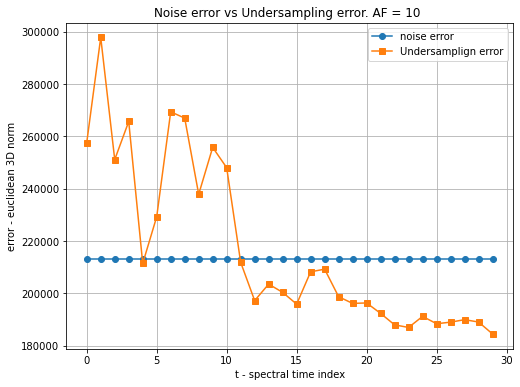

In [2]:
LowRank = False # assumes that ground truth and undersampling are done based on lowrank denoising, if false fullrank

trancuate_t = 96
AF = 3
Patient = 4

### Load data and tracuate
if LowRank:
    Ground_Truth = np.load('../data/Low_Rank_8_P03-P08_masked.npy')
    Undersampled_Data = np.load(f'../data/Undersampled_Data_P03-P08_LowRank/Undersampled_possoin_3D_fixed_r0_AF_{AF}.npy')
else:
    Ground_Truth = np.load('../data/Full_Rank_All_trancuated_k_space_masked.npy')
    Undersampled_Data = np.load(f'../data/Undersampled_Data_P03-P08/Undersampled_possoin_3D_fixed_r0_AF_{AF}.npy')
    
ground_truth_trancuated = Ground_Truth[:,:,:,:trancuate_t,:,:]
Undersampled_Data_trancuated = Undersampled_Data[:,:,:,:trancuate_t,:,:]

# if mask:
#     ground_truth_trancuated = apply_masks(ground_truth_trancuated, MASKS)
#     Undersampled_Data_trancuated = apply_masks(Undersampled_Data_trancuated, MASKS)
#     Ground_Truth = apply_masks(Ground_Truth, MASKS)
    
#### extract noise, from patient P08 who has an extremely similar noise profile
noise = np.abs(Ground_Truth[:,:,:,94,:,:])[..., Patient]

undersampling_error = np.abs(ground_truth_trancuated - Undersampled_Data_trancuated)[..., Patient]


#### Compute 2 Norm
noise_norm = np.sqrt(np.sum(noise**2, axis=(0, 1, 2))) ## compute 3D norm
undersampling_error_norm = np.sqrt(np.sum(undersampling_error**2, axis=(0, 1, 2)))

#### Average over T
noise_norm = np.mean(noise_norm, axis=0)*np.ones(trancuate_t)
undersampling_error_norm = np.mean(undersampling_error_norm, axis=1)

#### PLOT!!!

# Create a new figure
plt.figure(figsize=(8, 6))

# Plot the two lists; you can add markers if desired.
plt.plot(noise_norm, label="noise error", marker='o')
plt.plot(undersampling_error_norm, label="Undersamplign error", marker='s')

# Add labels and title
plt.xlabel("t - spectral time index")
plt.ylabel("error - euclidean 3D norm")
plt.title(f"Noise error vs Undersampling error. AF = {AF} ")

# Add a legend to indicate which line corresponds to which list.
plt.legend()

# Optionally, add a grid for easier visualization.
plt.grid(True)

# ***Regular Undersampling***

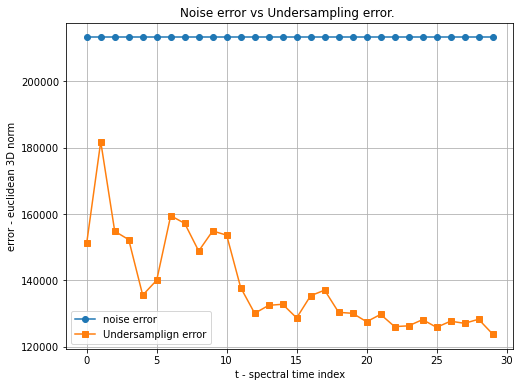

In [3]:
LowRank = False # assumes that ground truth and undersampling are done based on lowrank denoising, if false fullrank

trancuate_t = 30
Patient = 4

### Load data and tracuate
### Load data and tracuate
if LowRank:
    Ground_Truth = np.load('../data/Low_Rank_8_P03-P08_masked.npy')
    Undersampled_Data = np.load(f'../data/Undersampled_Data_P03-P08_LowRank/Undersampled_Regular.npy')
else:
    Ground_Truth = np.load('../data/Full_Rank_All_trancuated_k_space_masked.npy')
    Undersampled_Data = np.load(f'../data/Undersampled_Data_P03-P08/Undersampled_Regular.npy')

ground_truth_trancuated = Ground_Truth[:,:,:,:trancuate_t,:,:]

### Load undersampled data and trancuate
Undersampled_Data_trancuated = Undersampled_Data[:,:,:,:trancuate_t,:,:]
   
#### extract noise, add it to ground truth to create noise equivalent ground truth
noise = np.abs(Ground_Truth[:,:,:,94,:,:])[..., Patient]

undersampling_error = np.abs(ground_truth_trancuated - Undersampled_Data_trancuated)[..., Patient]


#### Compute 2 Norm
noise_norm = np.sqrt(np.sum(noise**2, axis=(0, 1, 2))) ## compute 3D norm
undersampling_error_norm = np.sqrt(np.sum(undersampling_error**2, axis=(0, 1, 2)))

#### Average over T
noise_norm = np.mean(noise_norm, axis=0)*np.ones(trancuate_t)
undersampling_error_norm = np.mean(undersampling_error_norm, axis=1)

#### PLOT!!!

# Create a new figure
plt.figure(figsize=(8, 6))

# Plot the two lists; you can add markers if desired.
plt.plot(noise_norm, label="noise error", marker='o')
plt.plot(undersampling_error_norm, label="Undersamplign error", marker='s')

# Add labels and title
plt.xlabel("t - spectral time index")
plt.ylabel("error - euclidean 3D norm")
plt.title(f"Noise error vs Undersampling error. ")

# Add a legend to indicate which line corresponds to which list.
plt.legend()

# Optionally, add a grid for easier visualization.
plt.grid(True)


# ***Compare ground truth to undersampled***

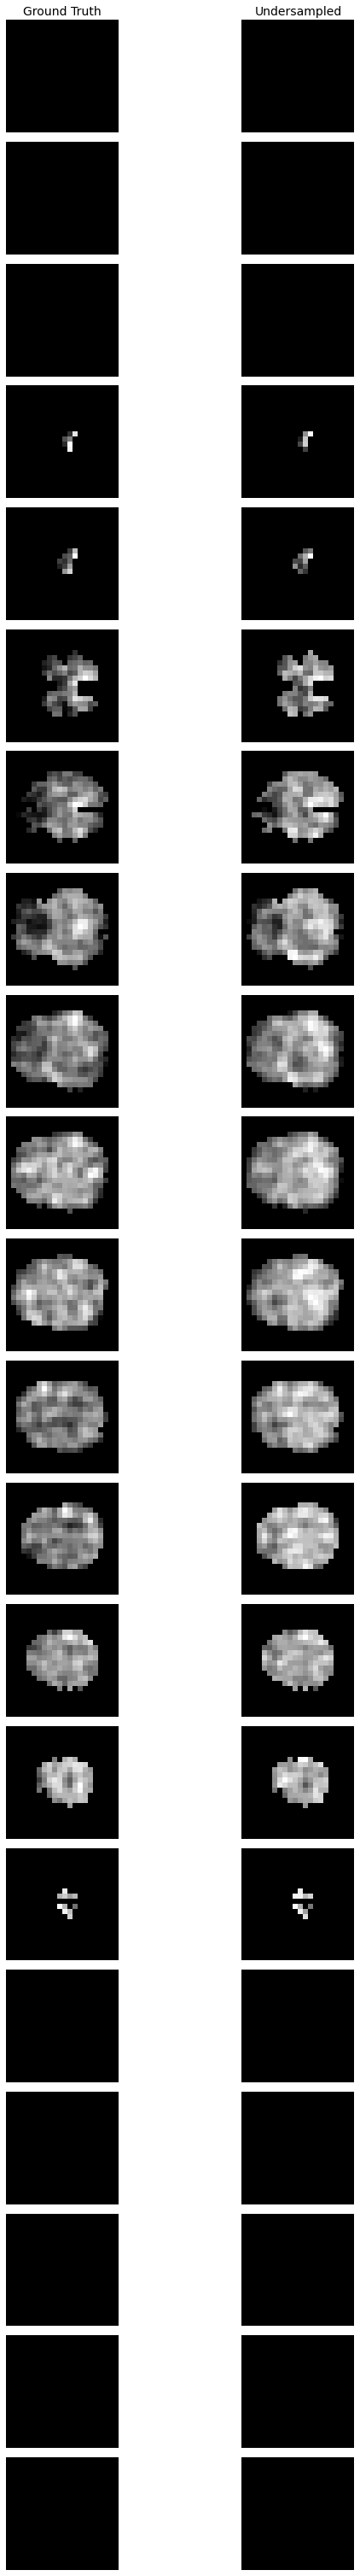

In [4]:
# Example indices (adjust as needed)
t = 10
T = 5
Patient = 0

# Extract the absolute values from the ground truth and undersampled data
# (Assuming your arrays have at least 6 dimensions as shown)
ground_truth_trancuated_abs = np.abs(ground_truth_trancuated)[:, :, :, t, T, Patient]
Undersampled_Data_trancuated_abs = np.abs(Undersampled_Data_trancuated)[:, :, :, t, T, Patient]

# Create a figure with 21 rows and 2 columns.
# Increase the overall figure size to give each subplot more room.
fig, axes = plt.subplots(21, 2, figsize=(10, 42))

# Add column titles to the top row of subplots.
axes[0, 0].set_title('Ground Truth', fontsize=14)
axes[0, 1].set_title('Undersampled', fontsize=14)

# Loop over the 21 slices and display each in its corresponding subplot.
for i in range(21):
    # Left column: Ground Truth image
    axes[i, 0].imshow(ground_truth_trancuated_abs[:, :, i], cmap='gray')
    axes[i, 0].axis('off')
    
    # Right column: Undersampled image
    axes[i, 1].imshow(Undersampled_Data_trancuated_abs[:, :, i], cmap='gray')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()